<a href="https://colab.research.google.com/github/elyakoubibouchra/elyakoubibouchra/blob/main/diabetes-classification-nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """
        Initialize Adam optimizer with hyperparameters.
        """
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"
        assert 0 <= beta1 < 1, "beta1 must be in [0, 1)"
        assert 0 <= beta2 < 1, "beta2 must be in [0, 1)"
        assert epsilon > 0, "epsilon must be positive"

        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_weights = None
        self.v_weights = None
        self.m_biases = None
        self.v_biases = None
        self.t = 0  # Time step

    def initialize(self, weights, biases):
        """
        Initialize moment estimates for weights and biases.
        """
        self.m_weights = [np.zeros_like(w) for w in weights]
        self.v_weights = [np.zeros_like(w) for w in weights]
        self.m_biases = [np.zeros_like(b) for b in biases]
        self.v_biases = [np.zeros_like(b) for b in biases]

    def update(self, weights, biases, d_weights, d_biases):
        """
        Update weights and biases using Adam optimization.
        """
        assert self.m_weights is not None, "Optimizer must be initialized before updating"
        assert len(weights) == len(d_weights) == len(self.m_weights) == len(self.v_weights), "Weight dimensions mismatch"
        assert len(biases) == len(d_biases) == len(self.m_biases) == len(self.v_biases), "Bias dimensions mismatch"

        self.t += 1  # Increment time step
        new_weights = [w.copy() for w in weights]
        new_biases = [b.copy() for b in biases]

        for i in range(len(weights)):
            # Update moving averages for weights
            self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * d_weights[i]
            self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (d_weights[i] ** 2)

            # Bias-corrected moments
            m_hat = self.m_weights[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v_weights[i] / (1 - self.beta2 ** self.t)

            # Update weights
            new_weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

            # Update moving averages for biases
            self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * d_biases[i]
            self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (d_biases[i] ** 2)

            # Bias-corrected moments
            m_hat_b = self.m_biases[i] / (1 - self.beta1 ** self.t)
            v_hat_b = self.v_biases[i] / (1 - self.beta2 ** self.t)

            # Update biases
            new_biases[i] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

        return new_weights, new_biases

Epoch 0, Train Loss: 0.7499, Val Loss: 0.6911, Train Acc: 0.6517, Val Acc: 0.6519
Epoch 10, Train Loss: 0.5889, Val Loss: 0.5325, Train Acc: 0.6517, Val Acc: 0.6519
Epoch 20, Train Loss: 0.5474, Val Loss: 0.5083, Train Acc: 0.6517, Val Acc: 0.6519
Epoch 30, Train Loss: 0.5264, Val Loss: 0.5059, Train Acc: 0.7960, Val Acc: 0.7556
Epoch 40, Train Loss: 0.5195, Val Loss: 0.5035, Train Acc: 0.7985, Val Acc: 0.8000
Epoch 50, Train Loss: 0.5144, Val Loss: 0.5025, Train Acc: 0.7811, Val Acc: 0.8000
Epoch 60, Train Loss: 0.5079, Val Loss: 0.5004, Train Acc: 0.7736, Val Acc: 0.8074
Epoch 70, Train Loss: 0.5071, Val Loss: 0.5000, Train Acc: 0.7736, Val Acc: 0.8000
Epoch 80, Train Loss: 0.4936, Val Loss: 0.4988, Train Acc: 0.7786, Val Acc: 0.8000
Epoch 90, Train Loss: 0.4904, Val Loss: 0.4990, Train Acc: 0.7910, Val Acc: 0.7852

Rapport de classification (Test set):
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       150
           1       0.68

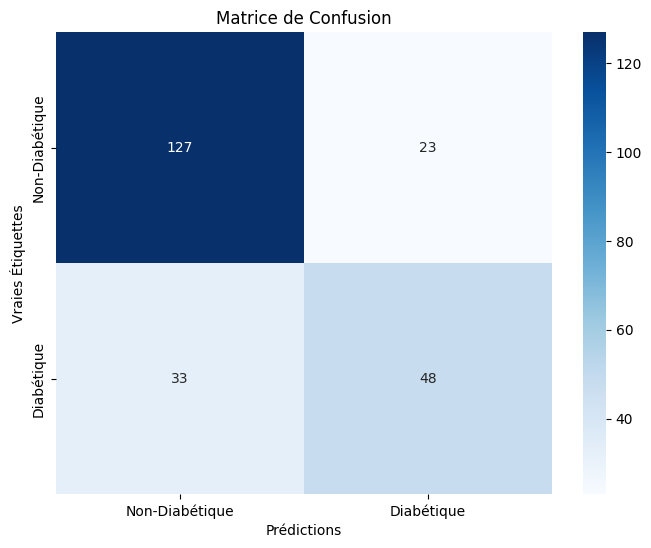

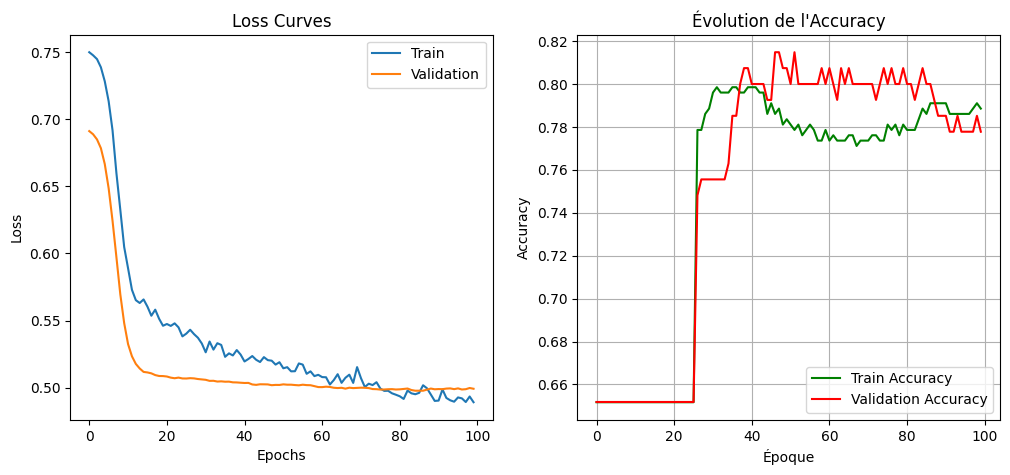

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Activation Functions
def relu(x):
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = np.where(x > 0, 1, 0)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def sigmoid(x):
    assert isinstance(x, np.ndarray), "Input to sigmoid must be a numpy array"
    x_clipped = np.clip(x, -500, 500)
    result = 1 / (1 + np.exp(-x_clipped))
    assert np.all((result >= 0) & (result <= 1)), "Sigmoid output must be in [0, 1]"
    return result

def sigmoid_derivative(x):
    assert isinstance(x, np.ndarray), "Input to sigmoid derivative must be a numpy array"
    result = sigmoid(x) * (1 - sigmoid(x))
    assert np.all((result >= 0) & (result <= 0.25)), "Sigmoid derivative must be in [0, 0.25]"
    return result

# Class AdamOptimizer
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"
        assert 0 <= beta1 < 1, "beta1 must be in [0, 1)"
        assert 0 <= beta2 < 1, "beta2 must be in [0, 1)"
        assert epsilon > 0, "epsilon must be positive"
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_weights = None
        self.v_weights = None
        self.m_biases = None
        self.v_biases = None
        self.t = 0

    def initialize(self, weights, biases):
        self.m_weights = [np.zeros_like(w) for w in weights]
        self.v_weights = [np.zeros_like(w) for w in weights]
        self.m_biases = [np.zeros_like(b) for b in biases]
        self.v_biases = [np.zeros_like(b) for b in biases]

    def update(self, weights, biases, d_weights, d_biases):
        assert self.m_weights is not None, "Optimizer must be initialized before updating"
        assert len(weights) == len(d_weights) == len(self.m_weights) == len(self.v_weights), "Weight dimensions mismatch"
        assert len(biases) == len(d_biases) == len(self.m_biases) == len(self.v_biases), "Bias dimensions mismatch"
        self.t += 1
        new_weights = [w.copy() for w in weights]
        new_biases = [b.copy() for b in biases]
        for i in range(len(weights)):
            self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * d_weights[i]
            self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (d_weights[i] ** 2)
            m_hat = self.m_weights[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v_weights[i] / (1 - self.beta2 ** self.t)
            new_weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * d_biases[i]
            self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (d_biases[i] ** 2)
            m_hat_b = self.m_biases[i] / (1 - self.beta1 ** self.t)
            v_hat_b = self.v_biases[i] / (1 - self.beta2 ** self.t)
            new_biases[i] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)
        return new_weights, new_biases

# Class NeuralNetwork
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, lamda=0.1, optimiseur='SGD'):
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        self.lamda = lamda
        self.optimiseur = optimiseur
        self.optimizer_instance = None
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01
            b = np.zeros((1, layer_sizes[i + 1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i + 1]), f"Weight matrix {i + 1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i + 1]), f"Bias vector {i + 1} has incorrect shape"
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i + 1]), f"Z^{[i + 1]} has incorrect shape"
            self.z_values.append(z)
            a = relu(z)
            assert a.shape == (X.shape[0], self.layer_sizes[i + 1]), f"A^{[i + 1]} has incorrect shape"
            self.activations.append(a)
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        self.z_values.append(z)
        output = sigmoid(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.activations.append(output)
        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        assert np.all((y_true == 0) | (y_true == 1)), "y_true must contain only 0s and 1s"
        y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
        m = y_true.shape[0]
        loss = -1 / m * np.sum(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss

    def compute_accuracy(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        y_pred_binary = (y_pred > 0.5).astype(int)
        correct_predictions = np.sum(y_true == y_pred_binary)
        accuracy = correct_predictions / y_true.shape[0]
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        dZ = outputs - y
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights) - 2, -1, -1):
            dA = dZ @ self.weights[i + 1].T
            dZ = dA * relu_derivative(self.z_values[i])
            assert dZ.shape == self.z_values[i].shape, f"dZ for layer {i + 1} has incorrect shape"
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights)):
            self.d_weights[i] += self.lamda * self.weights[i] / m

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        if self.optimiseur == 'Adam':
            self.optimizer_instance = AdamOptimizer(learning_rate=self.learning_rate)
            self.optimizer_instance.initialize(self.weights, self.biases)
        elif self.optimiseur != 'SGD':
            raise ValueError(f"Optimizer '{self.optimiseur}' not supported. Choose 'SGD' or 'Adam'.")
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            epoch_loss = 0
            if batch_size > X_shuffled.shape[0]:
                print(f"Warning: Batch size ({batch_size}) is larger than the number of training samples ({X_shuffled.shape[0]}). Using full dataset as a single batch.")
                batch_size = X_shuffled.shape[0]
            num_batches = max(1, X_shuffled.shape[0] // batch_size)
            for i in range(0, X_shuffled.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)
                if self.optimiseur == 'SGD':
                    for j in range(len(self.weights)):
                        self.weights[j] -= self.learning_rate * self.d_weights[j]
                        self.biases[j] -= self.learning_rate * self.d_biases[j]
                elif self.optimiseur == 'Adam':
                    self.weights, self.biases = self.optimizer_instance.update(self.weights, self.biases, self.d_weights, self.d_biases)
            train_loss = epoch_loss / num_batches
            train_outputs_full = self.forward(X_shuffled)
            train_accuracy = self.compute_accuracy(y_shuffled, train_outputs_full)
            val_outputs = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_outputs)
            val_accuracy = self.compute_accuracy(y_val, val_outputs)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        predictions = self.forward(X)
        predictions = (predictions > 0.5).astype(int)
        assert predictions.shape == (X.shape[0], self.layer_sizes[-1]), "Predictions have incorrect shape"
        return predictions

# Load and preprocess the data
data = pd.read_csv('diabetes.csv')
colonnes = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in colonnes:
    data[col] = data[col].replace(0, data[col].median())
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values
y = y.reshape(-1, 1)
assert X.shape[0] == y.shape[0], "Number of samples in X and y must match"
assert X.shape[1] == 8, "Expected 8 features in input data"
mu = np.mean(X, axis=0)
sigma = np.std(X, axis=0)
X = (X - mu) / sigma
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], "Train-val-test split sizes must sum to total samples"

# Create and train the model using Adam optimizer
layer_sizes = [X_train.shape[1], 16, 8, 1]
nn = NeuralNetwork(layer_sizes, learning_rate=0.001, lamda=0.1, optimiseur='Adam')  # Utiliser Adam
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)

# Predictions and evaluation
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set):")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabétique', 'Diabétique'], yticklabels=['Non-Diabétique', 'Diabétique'])
plt.title('Matrice de Confusion')
plt.ylabel('Vraies Étiquettes')
plt.xlabel('Prédictions')
plt.show()

# Loss and accuracy curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Validation')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves')
ax1.legend()
ax2.plot(train_accuracies, label='Train Accuracy', color='green')
ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
ax2.set_title('Évolution de l\'Accuracy')
ax2.set_xlabel('Époque')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)
plt.show()